# Paper plots

This notebook reproduces all of the plots in the paper.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import windows
from analysis import load_model, load_domain
from domains import itergrid, ActiveRectangularDomainND
from main import full_model_FBPINN, full_model_PINN, _x_mesh

from paper_plots import letters, savefig, get_lim, plot_loss, plot_im
from paper_plots import plot_2D_domain_cross_section, plot_1D_output, plot_1D_FBPINN_individual, plot_1D_domain

device = torch.device("cpu")
rootdir = "server/e1/"

## 1D problems

### Cos1D_1_w1, Cos1D_1_w15

In [2]:
# define runs
pinn_runs =   [
    "final_PINN_Cos1D_1_w1_16h_2l_200b_m",
    "final_PINN_Cos1D_1_w15_16h_2l_3000b_m",
    "final_PINN_Cos1D_1_w15_64h_4l_3000b_m",
    "final_PINN_Cos1D_1_w15_128h_5l_3000b_m",
              ]
fbpinn_runs = [
    "final_FBPINN_Cos1D_1_w1_16h_2l_200b_m_0.7w_All",
    "final_FBPINN_Cos1D_1_w1_16h_2l_200b_m_0.1w_All",
    "final_FBPINN_Cos1D_1_w15_16h_2l_3000b_m_0.7w_All",
              ]

# load models
pinns = [load_model(run, rootdir=rootdir, verbose=True) for run in pinn_runs]
fbpinns = [load_model(run, rootdir=rootdir, verbose=True) for run in fbpinn_runs]

# define test inputs, exact solution
c1 = fbpinns[0][1]
x_test1 = _x_mesh(c1.SUBDOMAIN_XS, (1000,), device)
yj_true1 = c1.P.exact_solution(x_test1, (1000,))

# define test inputs, exact solution
c2 = fbpinns[2][1]
x_test2 = _x_mesh(c2.SUBDOMAIN_XS, (1000,), device)
yj_true2 = c2.P.exact_solution(x_test2, (1000,))

# get FBPINN domain
D1 = load_domain(c1)
D2 = load_domain(c2)

# run inference
outputs1p = [full_model_PINN(x_test1, model, c) for model,c,_ in pinns[:1]]
outputs2p = [full_model_PINN(x_test2, model, c) for model,c,_ in pinns[1:]]
outputs1f = [full_model_FBPINN(x_test1, models, c, D1) for models,c,_ in fbpinns[:2]]
outputs2f = [full_model_FBPINN(x_test2, models, c, D2) for models,c,_ in fbpinns[2:]]

Loading model from:
server/e1/models/final_PINN_Cos1D_1_w1_16h_2l_200b_m/model_00050000.torch
Loading model from:
server/e1/models/final_PINN_Cos1D_1_w15_16h_2l_3000b_m/model_00050000.torch
Loading model from:
server/e1/models/final_PINN_Cos1D_1_w15_64h_4l_3000b_m/model_00050000.torch
Loading model from:
server/e1/models/final_PINN_Cos1D_1_w15_128h_5l_3000b_m/model_00050000.torch
Loading models from:
server/e1/models/final_FBPINN_Cos1D_1_w1_16h_2l_200b_m_0.7w_All/model_00050000_00000000.torch, ...
server/e1/models/final_FBPINN_Cos1D_1_w1_16h_2l_200b_m_0.7w_All/model_00050000_00000004.torch
Loading models from:
server/e1/models/final_FBPINN_Cos1D_1_w1_16h_2l_200b_m_0.1w_All/model_00050000_00000000.torch, ...
server/e1/models/final_FBPINN_Cos1D_1_w1_16h_2l_200b_m_0.1w_All/model_00050000_00000004.torch
Loading models from:
server/e1/models/final_FBPINN_Cos1D_1_w15_16h_2l_3000b_m_0.7w_All/model_00050000_00000000.torch, ...
server/e1/models/final_FBPINN_Cos1D_1_w15_16h_2l_3000b_m_0.7w_All/m

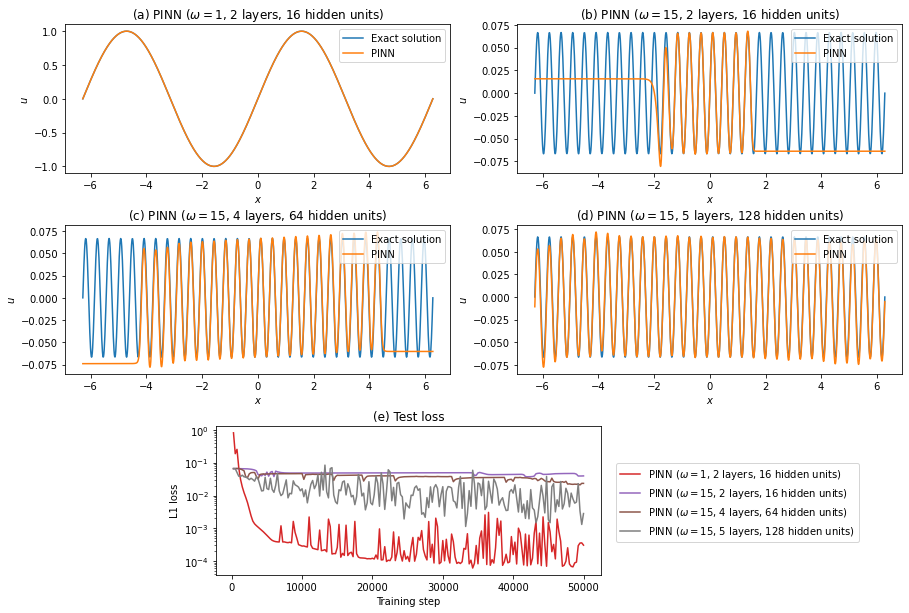

In [3]:
# PLOT

f = plt.figure(figsize=1.5*np.array([2*5,3*2.25]))
shape = (3,6)

plt.subplot2grid(shape, (0,0), colspan=3)

title = "%s PINN ($\omega = %i$, %s layers, %s hidden units)"%(letters[0],
                                                               pinns[:1][0][1].P.w, 
                                                               pinns[:1][0][1].N_LAYERS, 
                                                               pinns[:1][0][1].N_HIDDEN)
plot_1D_output(x_test1, yj_true1, outputs1p[0][0], "PINN", title, icolor=1)

for i,loc in enumerate([(0,3), (1,0), (1,3)]):
    
    plt.subplot2grid(shape, loc, colspan=3)
        
    title = "%s PINN ($\omega=%i$, %s layers, %s hidden units)"%(letters[1+i],
                                                                   pinns[1:][i][1].P.w, 
                                                                   pinns[1:][i][1].N_LAYERS, 
                                                                   pinns[1:][i][1].N_HIDDEN)
    plot_1D_output(x_test2, yj_true2, outputs2p[i][0], "PINN", title, icolor=1)

plt.subplot2grid(shape, (2,1), colspan=3)

losses_labels_icolors = \
    [(pinn[2][0], 
      "PINN ($\omega=%i$, %s layers, %s hidden units)"%(pinn[1].P.w, pinn[1].N_LAYERS, pinn[1].N_HIDDEN),
     3+i)
    for i,pinn in enumerate(pinns)]
plot_loss(losses_labels_icolors, "%s Test loss"%(letters[4]), (1.04, 0.22))

plt.subplots_adjust(hspace=0.35, wspace=0.8)
savefig(f, "cosp")
plt.show()

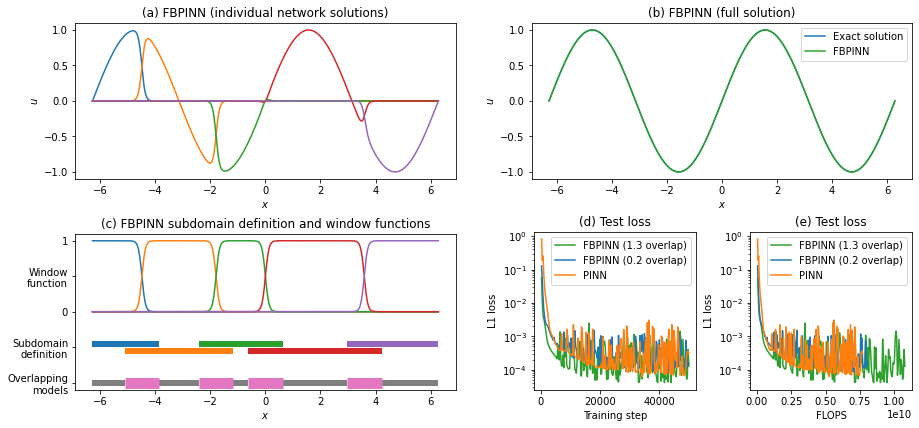

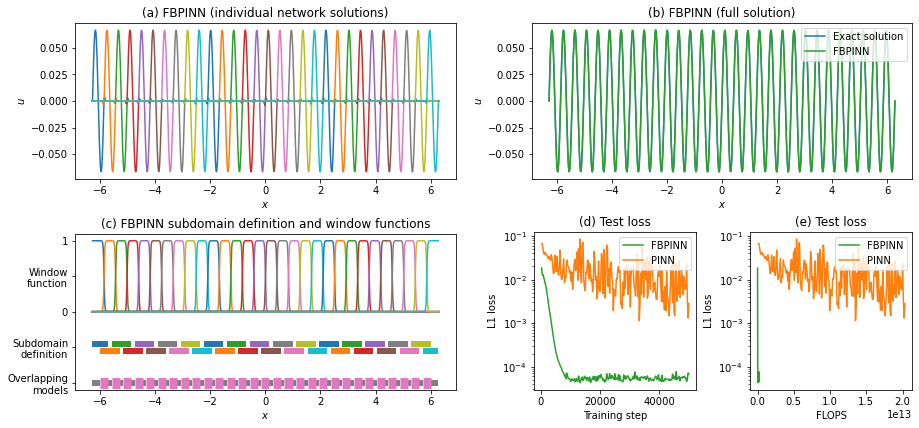

In [4]:
# PLOT
    
def figure_1D_FBPINN(x_test, yj_true, outputf, losses_labels_icolors, D, c):
    
    yj, yjs_bc, _ = outputf
    
    f = plt.figure(figsize=1.5*np.array([2*5,2*2.25]))
    
    plt.subplot(2,2,1)
    plot_1D_FBPINN_individual(x_test, yjs_bc, "%s FBPINN (individual network solutions)"%(letters[0]))
    
    plt.subplot(2,2,2)
    plot_1D_output(x_test, yj_true, yj, "FBPINN", "%s FBPINN (full solution)"%(letters[1]), icolor=2)
    
    plt.subplot(2,2,3)
    plot_1D_domain(c.SUBDOMAIN_XS, c.SUBDOMAIN_WS, D, "%s FBPINN subdomain definition and window functions"%(letters[2]))
    
    ax = f.add_axes([0.55, 0.125, 0.15, 0.325])# left, bottom, width, height
    plot_loss(losses_labels_icolors, "%s Test loss"%(letters[3]), "upper right", istep=0)
    
    ax = f.add_axes([0.75, 0.125, 0.15, 0.325])# left, bottom, width, height
    plot_loss(losses_labels_icolors, "%s Test loss"%(letters[4]), "upper right", istep=2)
    
    plt.subplots_adjust(hspace=0.35)
    
    return f

losses_labels_icolors = [(fbpinns[:2][0][2][0],"FBPINN (%.1f overlap)"%(fbpinns[:2][0][1].SUBDOMAIN_WS[0][0]),2), 
                         (fbpinns[:2][1][2][0],"FBPINN (%.1f overlap)"%(fbpinns[:2][1][1].SUBDOMAIN_WS[0][0]),0), 
                         (pinns[:1][0][2][0],"PINN",1)]
f = figure_1D_FBPINN(x_test1, yj_true1, outputs1f[0], losses_labels_icolors, D1, c1)
savefig(f, "cos1f")
plt.show()

losses_labels_icolors = [(fbpinns[2:][0][2][0],"FBPINN",2), 
                         (pinns[1:][-1][2][0],"PINN",1)]
f = figure_1D_FBPINN(x_test2, yj_true2, outputs2f[0], losses_labels_icolors, D2, c2)
savefig(f, "cos15f")
plt.show()

### Cos_multi1D_1_w1w15

In [5]:
# define runs
pinn_runs =   [
    "final_PINN_Cos_multi1D_1_w1w15_16h_2l_3000b_m",
    "final_PINN_Cos_multi1D_1_w1w15_64h_4l_3000b_m",
    "final_PINN_Cos_multi1D_1_w1w15_128h_5l_3000b_m",
              ]
fbpinn_runs = [
    "final_FBPINN_Cos_multi1D_1_w1w15_16h_2l_3000b_m_0.7w_All",
              ]

# load models
pinns = [load_model(run, rootdir=rootdir, verbose=True) for run in pinn_runs]
fbpinns = [load_model(run, rootdir=rootdir, verbose=True) for run in fbpinn_runs]

# define test inputs, exact solution
c2 = fbpinns[0][1]
x_test2 = _x_mesh(c2.SUBDOMAIN_XS, (1000,), device)
yj_true2 = c2.P.exact_solution(x_test2, (1000,))

# get FBPINN domain
D2 = load_domain(c2)

# run inference
outputs2p = [full_model_PINN(x_test2, model, c) for model,c,_ in pinns]
outputs2f = [full_model_FBPINN(x_test2, models, c, D2) for models,c,_ in fbpinns]

Loading model from:
server/e1/models/final_PINN_Cos_multi1D_1_w1w15_16h_2l_3000b_m/model_00050000.torch
Loading model from:
server/e1/models/final_PINN_Cos_multi1D_1_w1w15_64h_4l_3000b_m/model_00050000.torch
Loading model from:
server/e1/models/final_PINN_Cos_multi1D_1_w1w15_128h_5l_3000b_m/model_00050000.torch
Loading models from:
server/e1/models/final_FBPINN_Cos_multi1D_1_w1w15_16h_2l_3000b_m_0.7w_All/model_00050000_00000000.torch, ...
server/e1/models/final_FBPINN_Cos_multi1D_1_w1w15_16h_2l_3000b_m_0.7w_All/model_00050000_00000029.torch


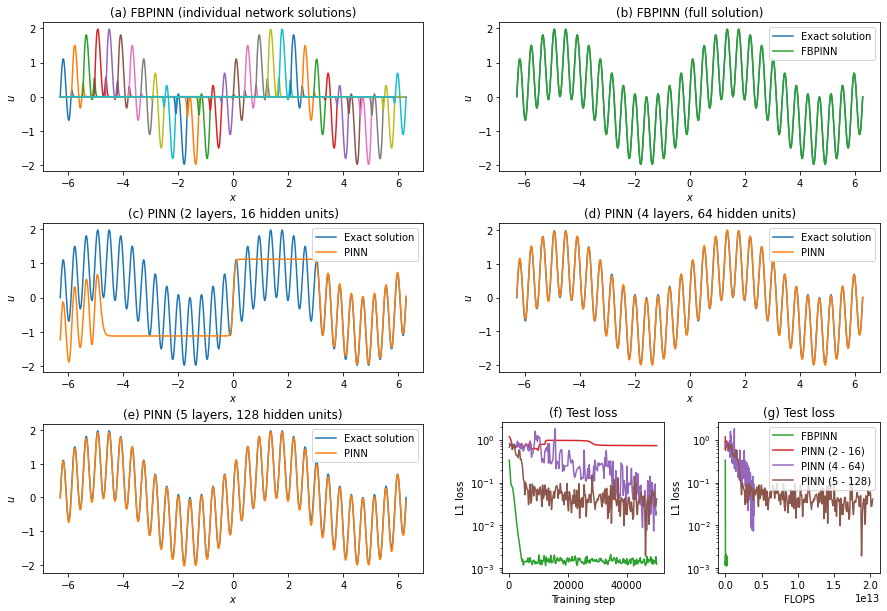

In [6]:
f = plt.figure(figsize=1.5*np.array([2*5,3*2.25]))

plt.subplot(3,2,1)
plot_1D_FBPINN_individual(x_test2, outputs2f[0][1], "%s FBPINN (individual network solutions)"%(letters[0]))

plt.subplot(3,2,2)
plot_1D_output(x_test2, yj_true2, outputs2f[0][0], "FBPINN", "%s FBPINN (full solution)"%(letters[1]), icolor=2)

for i in range(3):
    
    plt.subplot(3,2,3+i)
    
    title = "%s PINN (%s layers, %s hidden units)"%(letters[2+i], pinns[i][1].N_LAYERS, pinns[i][1].N_HIDDEN)
    plot_1D_output(x_test2, yj_true2, outputs2p[i][0], "PINN", title)

losses_labels_icolors = [(fbpinns[0][2][0],"FBPINN",2)] + \
                        [(pinns[i][2][0], 
                          "PINN (%s - %s)"%(pinns[i][1].N_LAYERS, pinns[i][1].N_HIDDEN), 3+i)
                         for i in range(3)]

ax = f.add_axes([0.55, 0.125, 0.15, 0.207])# left, bottom, width, height
plot_loss(losses_labels_icolors, "%s Test loss"%(letters[5]), "off", istep=0)

ax = f.add_axes([0.75, 0.125, 0.15, 0.207])# left, bottom, width, height
plot_loss(losses_labels_icolors, "%s Test loss"%(letters[6]), "upper right", istep=2)

plt.subplots_adjust(hspace=0.35)
    
savefig(f, "cosmulti")
plt.show()

### Sin1D_2_w15

In [7]:
# define runs
pinn_runs =   [
    "final_PINN_Sin1D_2_w15_128h_5l_3000b_m",
              ]
fbpinn_runs = [
    "final_FBPINN_Sin1D_2_w15_16h_2l_3000b_m_0.7w_Point",
    "final_FBPINN_Sin1D_2_w15_16h_2l_3000b_m_0.7w_All",
              ]

# load models
pinns = [load_model(run, rootdir=rootdir, verbose=True) for run in pinn_runs]
fbpinns = [load_model(run, rootdir=rootdir, verbose=True) for run in fbpinn_runs]
fbpinns_mid = [load_model(fbpinn_runs[0], i=i, rootdir=rootdir, verbose=True) for i in [20000, 200000]]

# define test inputs, exact solution
c2 = fbpinns[0][1]
x_test2 = _x_mesh(c2.SUBDOMAIN_XS, (1000,), device)
yj_true2 = c2.P.exact_solution(x_test2, (1000,))

# get FBPINN domain
D2 = load_domain(c2)

# run inference
outputs2p = [full_model_PINN(x_test2, model, c) for model,c,_ in pinns]
outputs2f = [full_model_FBPINN(x_test2, models, c, D2) for models,c,_ in fbpinns]
outputs2f_mid = [full_model_FBPINN(x_test2, models, c, D2) for models,c,_ in fbpinns_mid]

Loading model from:
server/e1/models/final_PINN_Sin1D_2_w15_128h_5l_3000b_m/model_00100000.torch
Loading models from:
server/e1/models/final_FBPINN_Sin1D_2_w15_16h_2l_3000b_m_0.7w_Point/model_00500000_00000000.torch, ...
server/e1/models/final_FBPINN_Sin1D_2_w15_16h_2l_3000b_m_0.7w_Point/model_00500000_00000029.torch
Loading models from:
server/e1/models/final_FBPINN_Sin1D_2_w15_16h_2l_3000b_m_0.7w_All/model_00100000_00000000.torch, ...
server/e1/models/final_FBPINN_Sin1D_2_w15_16h_2l_3000b_m_0.7w_All/model_00100000_00000029.torch
Loading models from:
server/e1/models/final_FBPINN_Sin1D_2_w15_16h_2l_3000b_m_0.7w_Point/model_00020000_00000000.torch, ...
server/e1/models/final_FBPINN_Sin1D_2_w15_16h_2l_3000b_m_0.7w_Point/model_00020000_00000029.torch
Loading models from:
server/e1/models/final_FBPINN_Sin1D_2_w15_16h_2l_3000b_m_0.7w_Point/model_00200000_00000000.torch, ...
server/e1/models/final_FBPINN_Sin1D_2_w15_16h_2l_3000b_m_0.7w_Point/model_00200000_00000029.torch


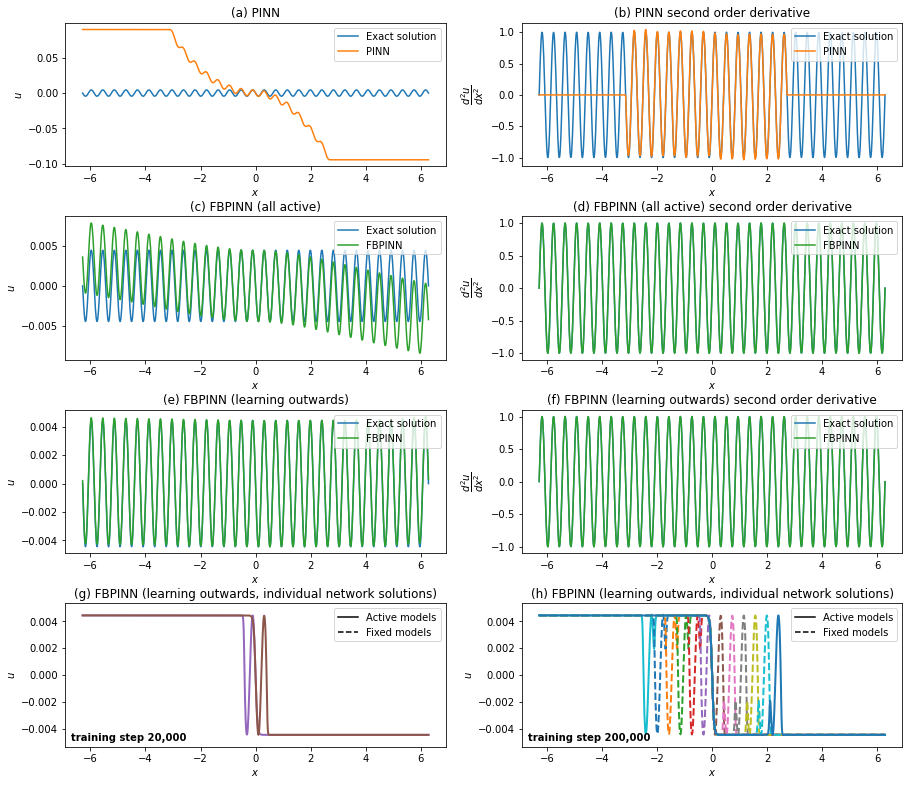

In [8]:
f = plt.figure(figsize=1.5*np.array([2*5,5*2.25]))
shape = (5,2)

for ir,output,t,label,icolor in zip(range(3), outputs2p+outputs2f[::-1], 
                         ["PINN", "FBPINN (all active)", "FBPINN (learning outwards)"],
                         ["PINN", "FBPINN", "FBPINN"],
                         [1,2,2]):
    for ic,j,ylabel in zip(range(2), [0,2], ["$u$", "$\dfrac{d^2 u}{d x^2}$"]):
        
        plt.subplot2grid(shape, (ir,ic))
        
        title = "%s %s"%(letters[ir*2+ic], t)
        if ic == 1: title += " second order derivative"
        plot_1D_output(x_test2, yj_true2, output[0], label, title, j, ylabel, icolor=icolor)

plt.subplot2grid(shape, (3,0))

plot_1D_FBPINN_individual(x_test2, outputs2f_mid[0][1], 
                          "%s FBPINN (learning outwards, individual network solutions)"%(letters[6]), 
                          fbpinns_mid[0][2][1])
plt.text(-6.7,-1.1*(1/15)**2,"training step 20,000", weight='demibold')
plt.ylim(-1.2*(1/15)**2, 1.2*(1/15)**2)

plt.subplot2grid(shape, (3,1))

plot_1D_FBPINN_individual(x_test2, outputs2f_mid[1][1], 
                          "%s FBPINN (learning outwards, individual network solutions)"%(letters[7]), 
                          fbpinns_mid[1][2][1])
plt.text(-6.7,-1.1*(1/15)**2,"training step 200,000", weight='demibold')
plt.ylim(-1.2*(1/15)**2, 1.2*(1/15)**2)

plt.subplots_adjust(hspace=0.35)

savefig(f, "sin15")
plt.show()

## 2D problems

### Cos_Cos2D_1

In [9]:
# define runs
pinn_runs =   [
    "final_PINN_Cos_Cos2D_1_w15_128h_5l_900b_m",
              ]
fbpinn_runs = [
    "final_FBPINN_Cos_Cos2D_1_w15_16h_2l_900b_m_0.7w_All",
              ]

# load models
pinns = [load_model(run, rootdir=rootdir, verbose=True) for run in pinn_runs]
fbpinns = [load_model(run, rootdir=rootdir, verbose=True) for run in fbpinn_runs]

# define test inputs, exact solution
batch_size_test = (200,200)
c1 = fbpinns[0][1]
x_test1 = _x_mesh(c1.SUBDOMAIN_XS, batch_size_test, device)
yj_true1 = c1.P.exact_solution(x_test1, batch_size_test)

# get FBPINN domain
D1 = load_domain(c1)

# run inference
outputs1p = [full_model_PINN(x_test1, model, c) for model,c,_ in pinns]
outputs1f = [full_model_FBPINN(x_test1, models, c, D1) for models,c,_ in fbpinns]

Loading model from:
server/e1/models/final_PINN_Cos_Cos2D_1_w15_128h_5l_900b_m/model_00050000.torch
Loading models from:
server/e1/models/final_FBPINN_Cos_Cos2D_1_w15_16h_2l_900b_m_0.7w_All/model_00050000_00000000.torch, ...
server/e1/models/final_FBPINN_Cos_Cos2D_1_w15_16h_2l_900b_m_0.7w_All/model_00050000_00000224.torch


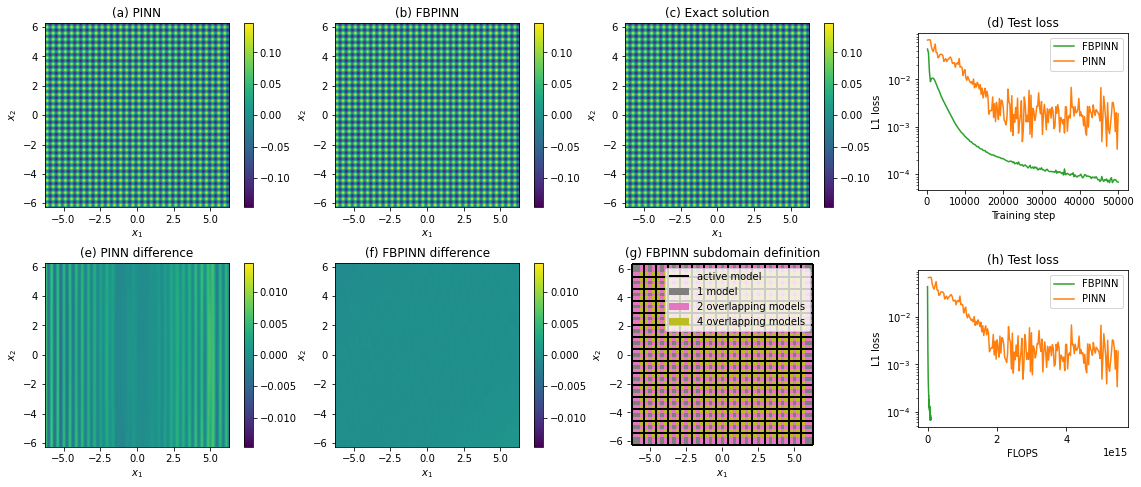

In [10]:
xlim, yjlims = get_lim(x_test1, yj_true1, c1)

f = plt.figure(figsize=1.3*np.array([4*4,2*3]))
shape = (2,4)

for i,(output,title) in enumerate(zip(outputs1p+outputs1f,["PINN", "FBPINN"])):
    
    plt.subplot2grid(shape, (0,i))
    
    plot_im(output[0][0], xlim, yjlims[0], batch_size_test, "%s %s"%(letters[i], title))

    plt.subplot2grid(shape, (1,i))
    
    plot_im(yj_true1[0] - output[0][0], xlim, 0.1*yjlims[0], batch_size_test, "%s %s difference"%(letters[4+i], title))
    
plt.subplot2grid(shape, (0,2))

plot_im(yj_true1[0], xlim, yjlims[0], batch_size_test, "%s Exact solution"%(letters[2]))

plt.subplot2grid(shape, (1,2))

plot_2D_domain_cross_section(c1.SUBDOMAIN_XS, D1, "%s FBPINN subdomain definition"%(letters[6]), [0,1], loc="upper right")

losses_labels_icolors = [(fbpinns[0][2][0],"FBPINN",2), (pinns[0][2][0],"PINN",1)]

ax = f.add_axes([0.74, 0.583, 0.14, 0.28])# left, bottom, width, height
plot_loss(losses_labels_icolors, "%s Test loss"%(letters[3]), "upper right", istep=0)

ax = f.add_axes([0.74, 0.16, 0.14, 0.28])# left, bottom, width, height
plot_loss(losses_labels_icolors, "%s Test loss"%(letters[7]), "upper right", istep=2)

plt.subplots_adjust(hspace=0.3, wspace=0)

savefig(f, "cos_cos15")
plt.show()

### Burgers2D

In [11]:
# define runs
pinn_runs =   [
    "final_PINN_Burgers2D_nu0.003_64h_4l_200b_m",
              ]
fbpinn_runs = [
    "final_FBPINN_Burgers2D_nu0.003_16h_2l_200b_m_0.7w_All",
    "final_FBPINN_Burgers2D_nu0.003_16h_2l_200b_m_0.7avoidw_All",
              ]

# load models
pinns = [load_model(run, rootdir=rootdir, verbose=True) for run in pinn_runs]
fbpinns = [load_model(run, rootdir=rootdir, verbose=True) for run in fbpinn_runs]

# define test inputs, exact solution
batch_size_test = (200,200)
c1 = fbpinns[0][1]
c2 = fbpinns[1][1]
x_test1 = _x_mesh(c1.SUBDOMAIN_XS, batch_size_test, device)
yj_true1 = c1.P.exact_solution(x_test1, batch_size_test)

# get FBPINN domain
D1 = load_domain(c1)
D2 = load_domain(c2)

# run inference
outputs1p = [full_model_PINN(x_test1, model, c) for model,c,_ in pinns]
outputs1f = [full_model_FBPINN(x_test1, models, c, D) for (models,c,_),D in zip(fbpinns, [D1, D2])]

Loading model from:
server/e1/models/final_PINN_Burgers2D_nu0.003_64h_4l_200b_m/model_00050000.torch
Loading models from:
server/e1/models/final_FBPINN_Burgers2D_nu0.003_16h_2l_200b_m_0.7w_All/model_00050000_00000000.torch, ...
server/e1/models/final_FBPINN_Burgers2D_nu0.003_16h_2l_200b_m_0.7w_All/model_00050000_00000007.torch
Loading models from:
server/e1/models/final_FBPINN_Burgers2D_nu0.003_16h_2l_200b_m_0.7avoidw_All/model_00050000_00000000.torch, ...
server/e1/models/final_FBPINN_Burgers2D_nu0.003_16h_2l_200b_m_0.7avoidw_All/model_00050000_00000005.torch


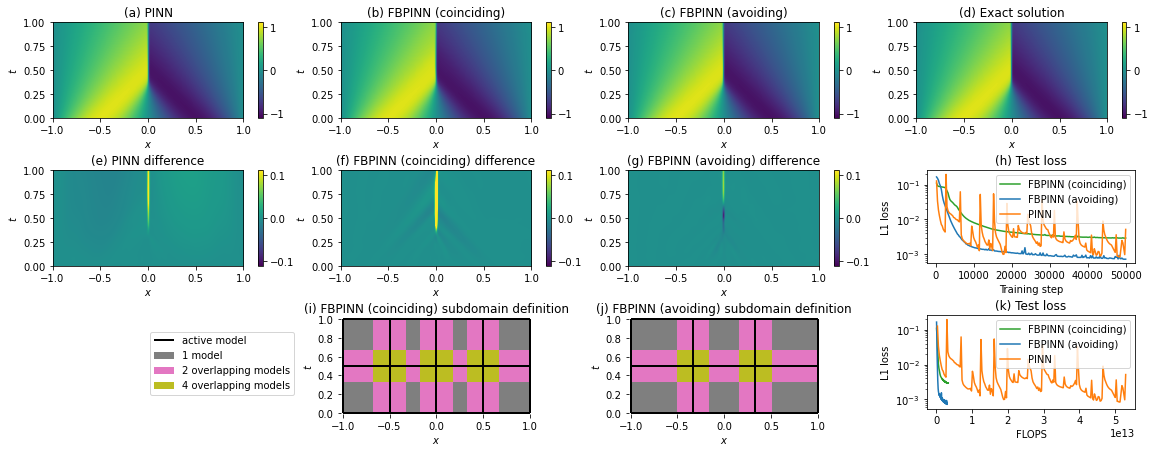

In [12]:
xlim, yjlims = get_lim(x_test1, yj_true1, c1)

f = plt.figure(figsize=1.2*np.array([4*4.3,3*2]))
shape = (3,4)

for i,(output,title) in enumerate(zip(outputs1p+outputs1f, ["PINN", "FBPINN (coinciding)", "FBPINN (avoiding)"])):
    
    plt.subplot2grid(shape, (0,i))
    
    plot_im(output[0][0], xlim, yjlims[0], batch_size_test, "%s %s"%(letters[i], title), xlabel="$x$", ylabel="$t$")

    plt.subplot2grid(shape, (1,i))
    
    plot_im(yj_true1[0] - output[0][0], xlim, 0.1*yjlims[0], batch_size_test, "%s %s difference"%(letters[4+i], title), xlabel="$x$", ylabel="$t$")
    
plt.subplot2grid(shape, (0,3))

plot_im(yj_true1[0], xlim, yjlims[0], batch_size_test, "%s Exact solution"%(letters[3]), xlabel="$x$", ylabel="$t$")

ax = plt.subplot2grid(shape, (2,1))

plot_2D_domain_cross_section(c1.SUBDOMAIN_XS, D1, "%s FBPINN (coinciding) subdomain definition"%(letters[8]), [0,1], loc=(-1,0.2))
ax.set_yticks(np.arange(0,1.2,0.2)); ax.set_anchor((0.41,0.5))
plt.xlabel("$x$"); plt.ylabel("$t$")

ax = plt.subplot2grid(shape, (2,2))

plot_2D_domain_cross_section(c2.SUBDOMAIN_XS, D2, "%s FBPINN (avoiding) subdomain definition"%(letters[9]), [0,1], loc=None)
ax.set_yticks(np.arange(0,1.2,0.2)); ax.set_anchor((0.41,0.5))
plt.xlabel("$x$"); plt.ylabel("$t$")

losses_labels_icolors = [(fbpinns[0][2][0],"FBPINN (coinciding)",2), 
                         (fbpinns[1][2][0],"FBPINN (avoiding)",0), 
                         (pinns[0][2][0],"PINN",1)]

ax = f.add_axes([0.74, 0.415, 0.14, 0.18])# left, bottom, width, height
plot_loss(losses_labels_icolors, "%s Test loss"%(letters[7]), "upper right", istep=0)

ax = f.add_axes([0.74, 0.135, 0.14, 0.18])# left, bottom, width, height
plot_loss(losses_labels_icolors, "%s Test loss"%(letters[10]), "upper right", istep=2)

plt.subplots_adjust(hspace=0.55, wspace=0.0)

savefig(f, "burgers")
plt.show()

## 3D problems

### WaveEquation3D

In [13]:
# define runs
pinn_runs =   [
    "final_PINN_WaveEquation3D_s0.3cgaussian_128h_5l_58b_r",
              ]
fbpinn_runs = [
    "final_FBPINN_WaveEquation3D_s0.3cgaussian_64h_4l_58b_r_0.9w_Plane",
    "final_FBPINN_WaveEquation3D_s0.3cgaussian_16h_2l_58b_r_0.9w_Plane",
              ]

# load models
pinns = [load_model(run, rootdir=rootdir, verbose=True) for run in pinn_runs]
fbpinns = [load_model(run, rootdir=rootdir, verbose=True) for run in fbpinn_runs]

# define test inputs, exact solution
batch_size_test = (100,100,4)
c1 = fbpinns[0][1]
x_test1 = _x_mesh(c1.SUBDOMAIN_XS, batch_size_test, device)
yj_true1 = c1.P.exact_solution(x_test1, batch_size_test)

# get FBPINN domain
D1 = load_domain(c1)

# run inference
outputs1p = [full_model_PINN(x_test1, model, c) for model,c,_ in pinns]
outputs1f = [full_model_FBPINN(x_test1, models, c, D1) for models,c,_ in fbpinns]

# get velocity model
v = c1.P.c(x_test1)

Loading model from:
server/e1/models/final_PINN_WaveEquation3D_s0.3cgaussian_128h_5l_58b_r/model_00070000.torch
Loading models from:
server/e1/models/final_FBPINN_WaveEquation3D_s0.3cgaussian_64h_4l_58b_r_0.9w_Plane/model_00150000_00000000.torch, ...
server/e1/models/final_FBPINN_WaveEquation3D_s0.3cgaussian_64h_4l_58b_r_0.9w_Plane/model_00150000_00000035.torch
Loading models from:
server/e1/models/final_FBPINN_WaveEquation3D_s0.3cgaussian_16h_2l_58b_r_0.9w_Plane/model_00150000_00000000.torch, ...
server/e1/models/final_FBPINN_WaveEquation3D_s0.3cgaussian_16h_2l_58b_r_0.9w_Plane/model_00150000_00000035.torch


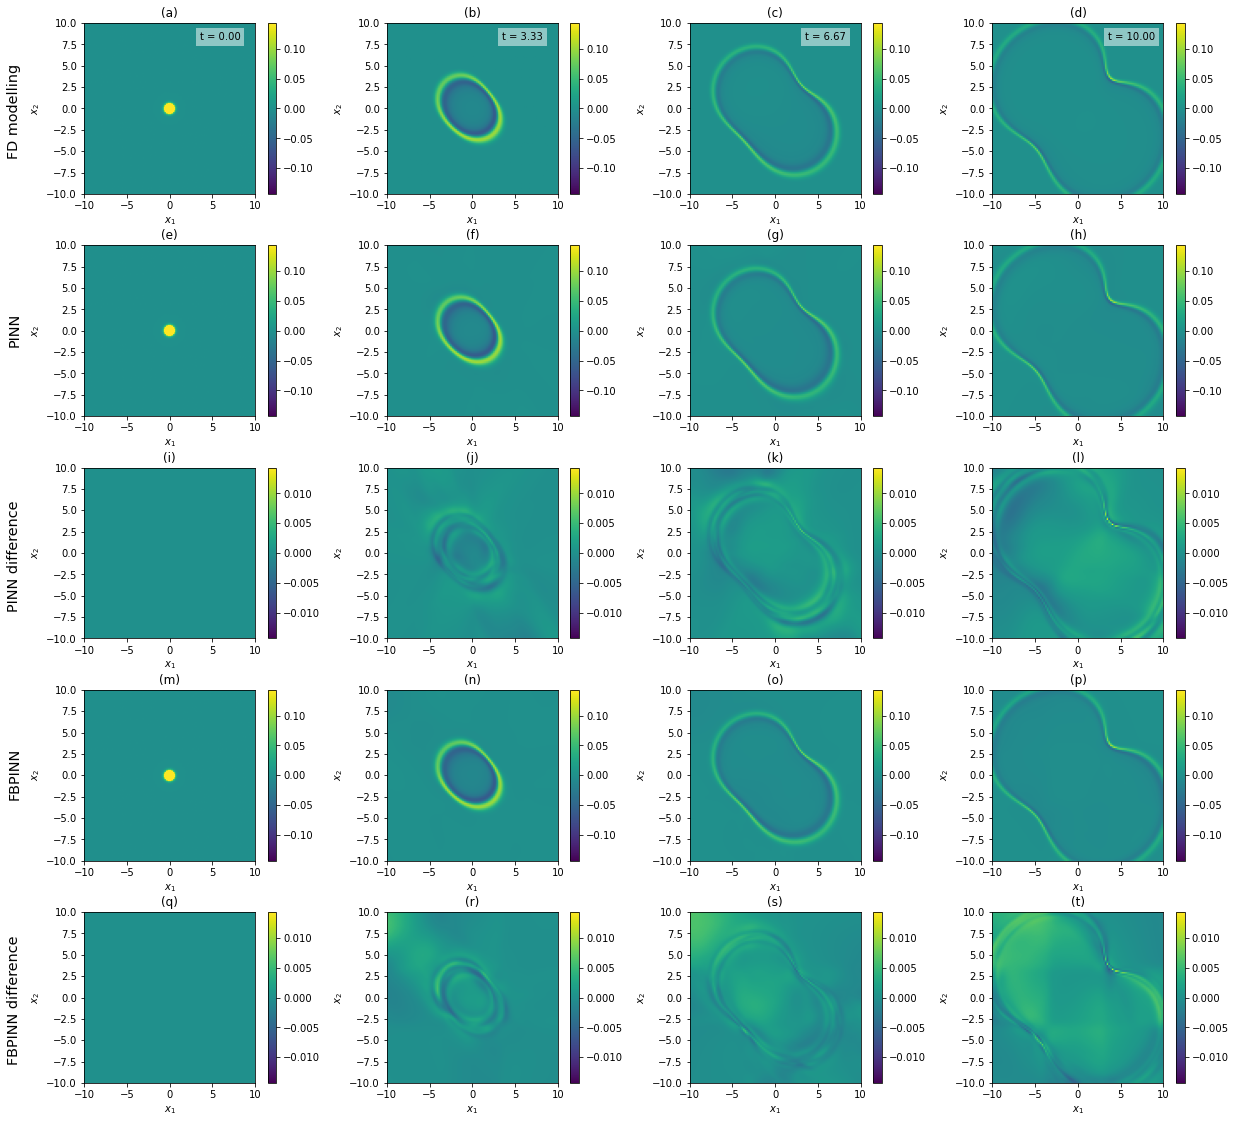

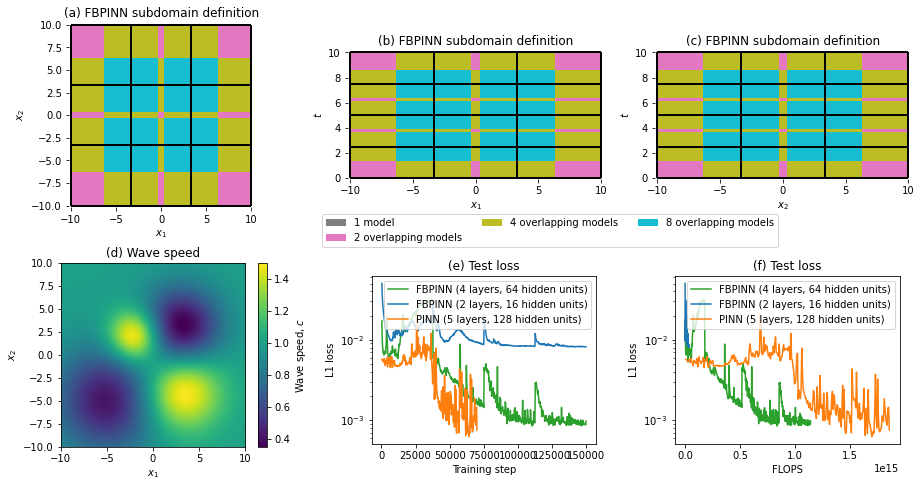

In [14]:
c1.PLOT_LIMS = (0.3, True)
xlim, yjlims = get_lim(x_test1, yj_true1, c1)
outputs = outputs1p + outputs1f[:1]

f = plt.figure(figsize=1.3*np.array([4*4,5*3]))
shape = (5,4)
for it in range(4):
    
    plt.subplot2grid(shape, (0,it))
    
    plot_im(yj_true1[0], xlim, yjlims[0], batch_size_test, letters[it], it)
    if it == 0: plt.text(-19, -5.5, "FD modelling", fontsize="x-large", rotation=90)
    plt.text(3.5,8., "t = %.2f"%(it*(xlim[1][2]-xlim[0][2])/3), 
             bbox=dict(facecolor='white', linewidth=0, alpha=0.5))
    
    for i,(output,title) in enumerate(zip(outputs, ["PINN", "FBPINN"])):
        
        plt.subplot2grid(shape, (1+2*i,it))
        
        plot_im(output[0][0], xlim, yjlims[0], batch_size_test, letters[4+(2*i)*4+it], it)
        if it == 0: plt.text(-19, (1-i)-2.5, title, fontsize="x-large", rotation=90)
        
        plt.subplot2grid(shape, (1+2*i+1,it))
        
        plot_im(yj_true1[0] - output[0][0], xlim, 0.1*yjlims[0], batch_size_test, letters[4+(2*i+1)*4+it], it)
        if it == 0: plt.text(-19, (1-i)-7.5, title + " difference", fontsize="x-large", rotation=90)
        
plt.subplots_adjust(hspace=0.3)

savefig(f, "wave2")
plt.show()


f = plt.figure(figsize=1.3*np.array([3*4,2*3]))
shape = (2,3)

for i,iaxes in enumerate([[0,1],[0,2],[1,2]]):
    
    ax = plt.subplot2grid(shape, (0,i))

    plot_2D_domain_cross_section(c1.SUBDOMAIN_XS, D1, "%s FBPINN subdomain definition"%(letters[i]), 
                                 iaxes, loc=(-0.1,-0.53) if i==1 else None, ncol=3, line_labels=False)
    if i == 0: ax.set_anchor((0.4,0.5))
        
plt.subplot2grid(shape, (1,0))

plot_im(v, xlim, (0.35,1.5), batch_size_test, "%s Wave speed"%(letters[3]), 0, "Wave speed, $c$")

losses_labels_icolors = [(fbpinns[0][2][0],"FBPINN (%s layers, %s hidden units)"%(fbpinns[0][1].N_LAYERS, fbpinns[0][1].N_HIDDEN),2), 
                         (fbpinns[1][2][0],"FBPINN (%s layers, %s hidden units)"%(fbpinns[1][1].N_LAYERS, fbpinns[1][1].N_HIDDEN),0), 
                         (pinns[0][2][0],"PINN (%s layers, %s hidden units)"%(pinns[0][1].N_LAYERS, pinns[0][1].N_HIDDEN),1)]

ax = f.add_axes([0.42, 0.13, 0.2, 0.3])# left, bottom, width, height
plot_loss(losses_labels_icolors, "%s Test loss"%(letters[4]), "upper right", istep=0)

ax = f.add_axes([0.69, 0.13, 0.2, 0.3])# left, bottom, width, height
plot_loss(losses_labels_icolors, "%s Test loss"%(letters[5]), "upper right", istep=2)

plt.subplots_adjust(hspace=0.3)

savefig(f, "wave1")
plt.show()

In [15]:
# define runs
pinn_runs =   [
    "final_PINN_WaveEquation3D_s0.3cgaussian_128h_5l_58b_r",
              ]
fbpinn_runs = [
    "final_FBPINN_WaveEquation3D_s0.3cgaussian_64h_4l_58b_r_0.9w_Plane",
              ]

# load models
pinns = [load_model(pinn_runs[0], i=i, rootdir=rootdir, verbose=True) for i in [20000,]]
fbpinns = [load_model(fbpinn_runs[0], i=i, rootdir=rootdir, verbose=True) for i in [50000, 100000]]

# define test inputs, exact solution
batch_size_test = (100,100,4)
c1 = fbpinns[0][1]
x_test1 = _x_mesh(c1.SUBDOMAIN_XS, batch_size_test, device)
yj_true1 = c1.P.exact_solution(x_test1, batch_size_test)

# get FBPINN domain
D1 = load_domain(c1)

# run inference
outputs1p = [full_model_PINN(x_test1, model, c) for model,c,_ in pinns]
outputs1f = [full_model_FBPINN(x_test1, models, c, D1) for models,c,_ in fbpinns]

Loading model from:
server/e1/models/final_PINN_WaveEquation3D_s0.3cgaussian_128h_5l_58b_r/model_00020000.torch
Loading models from:
server/e1/models/final_FBPINN_WaveEquation3D_s0.3cgaussian_64h_4l_58b_r_0.9w_Plane/model_00050000_00000000.torch, ...
server/e1/models/final_FBPINN_WaveEquation3D_s0.3cgaussian_64h_4l_58b_r_0.9w_Plane/model_00050000_00000035.torch
Loading models from:
server/e1/models/final_FBPINN_WaveEquation3D_s0.3cgaussian_64h_4l_58b_r_0.9w_Plane/model_00100000_00000000.torch, ...
server/e1/models/final_FBPINN_WaveEquation3D_s0.3cgaussian_64h_4l_58b_r_0.9w_Plane/model_00100000_00000035.torch


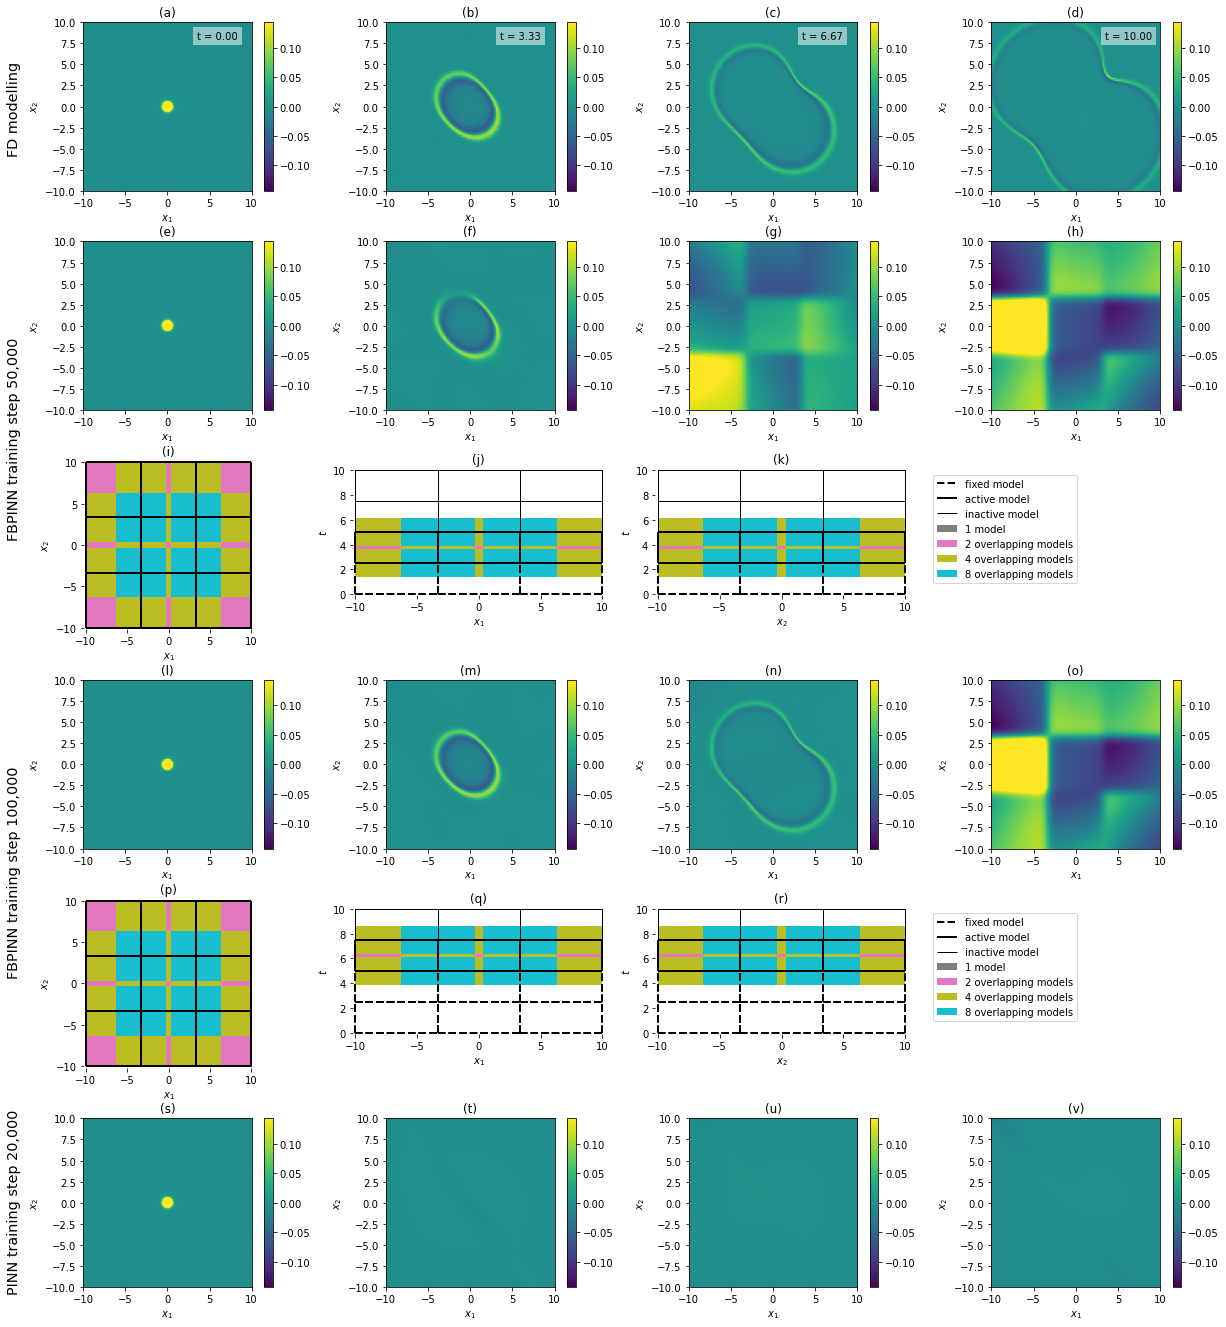

In [16]:
c1.PLOT_LIMS = (0.3, True)
xlim, yjlims = get_lim(x_test1, yj_true1, c1)
iaxess = [[0,1],[0,2],[1,2]]

f = plt.figure(figsize=1.3*np.array([4*4,7*3]))
shape = (7,4)
for it in range(4):
    
    # ground truth
    
    plt.subplot2grid(shape, (0,it))
        
    plot_im(yj_true1[0], xlim, yjlims[0], batch_size_test, letters[it], it)
    if it == 0: plt.text(-19, -5.5, "FD modelling", fontsize="x-large", rotation=90)
    plt.text(3.5,8., "t = %.2f"%(it*(xlim[1][2]-xlim[0][2])/3), 
             bbox=dict(facecolor='white', linewidth=0, alpha=0.5))
    
    # FBPINN
    
    for i,output in enumerate(outputs1f):
        
        plt.subplot2grid(shape, (1+2*i,it))
        
        plot_im(output[0][0], xlim, yjlims[0], batch_size_test, letters[it+i*7+4], it)
        if it == 0: plt.text(-19, -25, "FBPINN training step %s"%({0:"50,000",1:"100,000"}[i]), fontsize="x-large", rotation=90)
    
        if it <= 2:
            ax = plt.subplot2grid(shape, (1+2*i+1,it))
            D1.update_active(fbpinns[i][2][1])
            plot_2D_domain_cross_section(c1.SUBDOMAIN_XS, D1, letters[it+i*7+2*4], 
                                             iaxess[it], loc=(1.1,0.1) if it==2 else None, ncol=1)
            ax.set_anchor((0.41,0.5) if it==0 else (0.3, 0.8))
    
    # PINN
    
    plt.subplot2grid(shape, (5,it))
        
    plot_im(outputs1p[0][0][0], xlim, yjlims[0], batch_size_test, letters[it+2*7+4], it)
    if it == 0: plt.text(-19, -10.5, "PINN training step 20,000", fontsize="x-large", rotation=90)
    
plt.subplots_adjust(hspace=0.3)

savefig(f, "wave3")
plt.show()

## Workflow diagrams

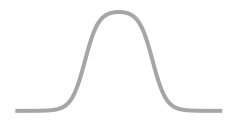

In [17]:
# window function
x = torch.linspace(-1.5,1.5,100).view(-1,1)
w = windows.construct_window_function_ND([-0.5], [0.5], [0.1], [0.1])
w1 = w(x)

f = plt.figure(figsize=(4,2))
plt.plot(x, w1, linewidth=4, color="#A6A6A6")
plt.box(on=None)
plt.axis("off")
savefig(f,"raw/raw_window", ext="png")
plt.show()

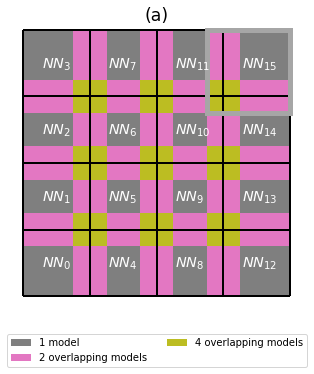

In [18]:
# subdomain grid
subdomain_xs = [np.array([-4,-2,0,2,4]), np.array([-4,-2,0,2,4])]
subdomain_ws = [np.array([1,1,1,1,1]), np.array([1,1,1,1,1])]
D = ActiveRectangularDomainND(subdomain_xs, subdomain_ws)
D.update_sampler((100,100),False)
D.update_active()

f = plt.figure(figsize=(5,5))
plot_2D_domain_cross_section(subdomain_xs, D, None, loc=(-0.05,-0.25), ncol=2, line_labels=False)
plt.xticks([]); plt.yticks([])
plt.xlabel(None); plt.ylabel(None)
plt.title("(a)", fontsize="xx-large")
for im,ii in itergrid(D.nm):
    plt.text(subdomain_xs[0][ii[0]]+0.55, subdomain_xs[1][ii[1]]+0.85, 
             "$NN_{%i}$"%(im), fontsize="x-large", color="white", zorder=11)
ax = plt.gca()
rect = patches.Rectangle((2-0.5,2-0.5), #xy (x,y)
                          2.5, #width (along x)
                          2.5, #height (along y)
                         linewidth=5, linestyle="-", edgecolor="#A6A6A6", facecolor="none", zorder=10)
ax.add_patch(rect)
savefig(f,"raw/raw_grid", "png")
plt.show()

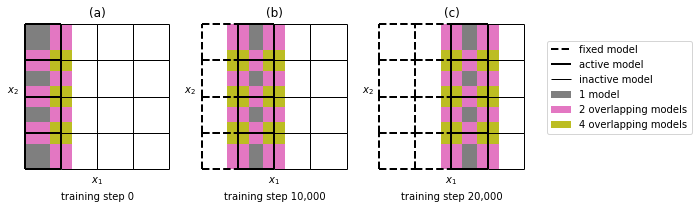

In [19]:
# active examples
subdomain_xs = [np.array([-4,-2,0,2,4]), np.array([-4,-2,0,2,4])]
subdomain_ws = [1.2*np.ones(5), 1.2*np.ones(5)]
D = ActiveRectangularDomainND(subdomain_xs, subdomain_ws)
D.update_sampler((100,100),False)
active1, active2, active3 = [np.zeros(D.nm, dtype=int) for _ in range(3)]
active1[0:1] = 1
active2[0:1] = 2
active2[1:2] = 1
active3[0:2] = 2
active3[2:3] = 1
active3[3:] = 0

locs = [(-2,"0"), (-2.8,"10,000"), (-2.8,"20,000")]
f = plt.figure(figsize=(3*3,3))
for i,active in enumerate([active1, active2, active3]):
    plt.subplot(1,3,1+i)
    D.update_active(active)
    plot_2D_domain_cross_section(subdomain_xs, D, letters[i], loc=(1.15,0.25) if i==2 else None)
    plt.xticks([]); plt.yticks([])
    plt.xlabel("$x_{1}$"); plt.ylabel("$x_{2}$", rotation=0, labelpad=10)
    plt.text(locs[i][0],-5.7,"training step %s"%(locs[i][1]))
savefig(f,"active", ext="pdf")
plt.show()